In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q git+https://github.com/tensorflow/docs
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

import librosa

import numpy as np
import pandas as pd
import random
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd
import librosa.display

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## 장르별 최적 파라미터 설정

|장르|epoch|latent_dim|best_perform|
|:------:|:------:|:------:|:------:|
|blues|5|8| 1, 2 |
|classical|5|8| 3, 4, 7, 10 |
|country|5|8| 3 |
|disco|5|8| 5, 9 |
|hiphop|5|8| 1 |
|jazz|5|5| 4, 5, 7 |
|metal|7|4| 1, 4, 5, 8 |
|pop|5|5|8|
|reggae|5|4| 7, 8, 10 |
|rock|5|5|3|


In [6]:
### hyperparameter
train_size = 60000
test_size = 10000

BATCH_SIZE = 10
epochs = 5
data_len=90001

# 축소 차원 수
latent_dim = 5

# 한번에 생성하는 음악 수
num_examples_to_generate = 10

BASE_PATH = '/content/drive/MyDrive/기계팀플/Data/genres_original'
SAVE_PATH = '/content/drive/MyDrive/기계팀플/Data/VAE_generate/'

## 모델 학습&생성 장르
# genre : blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock
genre = 'rock'

# 데이터 준비

In [7]:
def DatasetLoader(class_):
  train_list = []
  test_list = []

  music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
  train_music_1=[]
  train_music_2=[]

  # 초기화
  randint = random.randint(0,99)
  train_list.append(randint)

  # train_list 80개 랜덤추출
  for i in range(80) :
    # train_list에 이미 포함된 경우 재추출
    while randint in train_list :
      randint = random.randint(0,99)
    train_list.append(randint)
    train_music_1.append(music_list[[randint]][0])

  # train_list에 있는 숫자 제외하기 위한 리스트
  all_list = [i for i in range(100)]

  # test_list 20개 랜덤추출
  test_list = [i for i in all_list if i not in train_list]
  for i in test_list :
    train_music_2.append(music_list[[i]][0])
 
  TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
  TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

  return TrackSet_1, TrackSet_2

In [8]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,data_len)
    return data_
    
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [9]:
TrackSet_1, TrackSet_2 = DatasetLoader(genre)

In [10]:
for i in TrackSet_1 :
  data_, sampling_rate = librosa.load(i,sr=3000, offset=0.0, duration=30)
  if data_.shape != (data_len,):
    TrackSet_1.remove(i)

for i in TrackSet_2 :
  data_, sampling_rate = librosa.load(i,sr=3000, offset=0.0, duration=30)
  if data_.shape != (data_len,):
    TrackSet_2.remove(i)

In [11]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [12]:
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

## 모델 구조 정의 및 학습

In [13]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__()
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [14]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,data_len)),
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1,),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1,),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim,name="1")

            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(data_len,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [15]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [16]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)
    
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [17]:
## 학습 과정 이미지

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        print(wave)
        librosa.display.waveshow(wave[0], sr=3000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [18]:
## 음악 생성

def inference(test_dataset, model):  
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

In [19]:
## 학습

import soundfile as sf
from scipy.io.wavfile import write

def train(train_dataset, test_dataset, model, save):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo,  end_time - start_time ))

          #librosa.output.write_wav('blues epoch'+str(i)+"."+str(j)+".wav", music1, 3000)
        #sf.write('blues epoch'+str(i)+"."+str(j), music1, 3000, 'PCM_24')
        #saved_musics = inference(test_dataset, model)
        #for j in range(0,10):
         # music1=saved_musics[j][0]
          #write('{}_{:04d}_{:02d}.wav'.format(save, epoch,j), 3000, music1)

        model.save_weights("my_model_classical"+str(epoch)) 

        generate_and_save_images(model,epoch, test_sample, save)

Epoch: 5, Test set ELBO: -10309.7939453125, time elapse for current epoch: 32.810853481292725
[[0.21012726 0.20919299 0.17413925 ... 0.1871085  0.18255329 0.11993041]]
[[0.19476393 0.19352682 0.1582574  ... 0.17141323 0.1672324  0.10506749]]
[[0.08144537 0.08089031 0.05477918 ... 0.06393158 0.0607369  0.02527439]]
[[0.15795283 0.15731813 0.12274675 ... 0.13551573 0.13109516 0.07428927]]
[[0.17397963 0.1735043  0.13854292 ... 0.15174535 0.14657675 0.08748808]]
[[0.07079758 0.07046771 0.04639367 ... 0.05479326 0.05158231 0.02032247]]
[[0.15907079 0.15696216 0.12289172 ... 0.13520674 0.13127074 0.07436389]]
[[0.0582815  0.05789405 0.03676375 ... 0.0441575  0.04126089 0.01486524]]
[[0.08495411 0.08441453 0.05803391 ... 0.06745357 0.06361122 0.02712976]]
[[0.21800546 0.21660313 0.18228592 ... 0.1950041  0.19068141 0.12695795]]


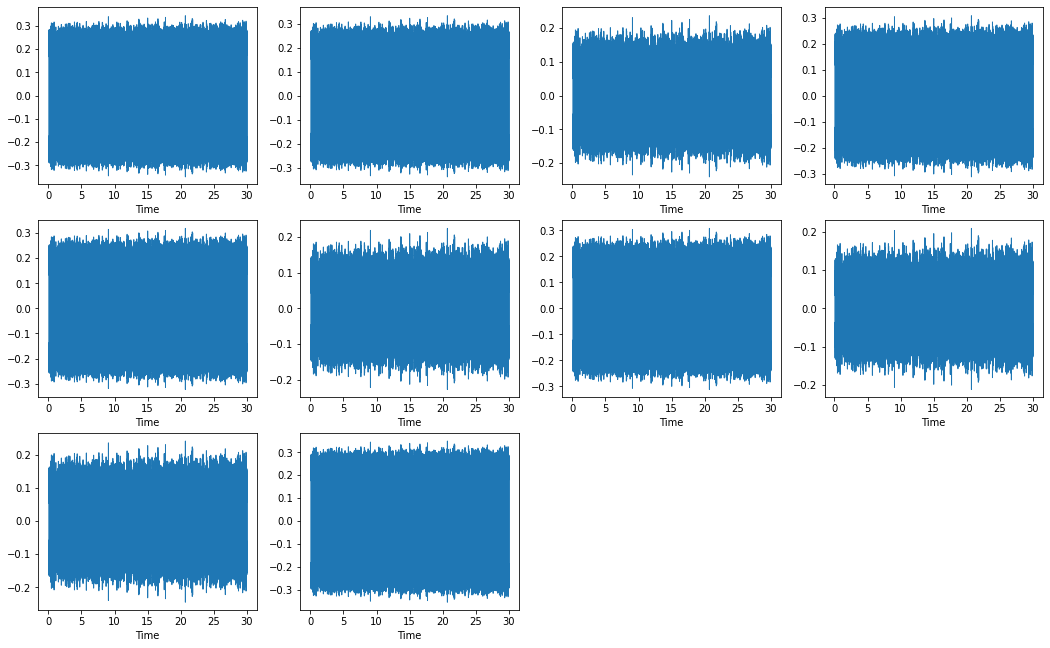

In [20]:
model = CVAE(latent_dim)

train(train_dataset, test_dataset, model, 'classical')

In [21]:
# epoch당 gif 파일 저장

anim_file_1 = 'classical_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('classical*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [22]:
saved_musics = inference(test_dataset, model)

In [23]:
music1=saved_musics[0][0]

print(" ")
print(" ")
print(" ")
print(" ")
print(" ")
print(" ")

ipd.Audio(music1,rate=3000)

In [24]:
music1=saved_musics[2][0]

print(" ")
print(" ")
print(" ")
print(" ")
print(" ")
print(" ")

ipd.Audio(music1,rate=3000)